In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

Using backend: tensorflow.compat.v1

2023-04-14 13:57:37.775566: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.


2023-04-14 13:58:20.211594: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-14 13:58:22.358332: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-14 13:58:22.358783: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
from deepxde.geometry.sampler import sample
import random as rnd

In [3]:
learning_rate = 1e-3
num_dense_layers = 6
num_dense_nodes = 150
iterations = 10000
activation = 'tanh'
weights = 100

In [4]:
nx_train = 100
nx_test = 300

In [5]:
L = 2
n_max = 5

In [1]:
class LogUniformPoints(Exception):
    pass

class UniformBoundaryPoints(Exception):
    pass

class PeriodicPoint(Exception):
    pass

class BackgroundPoints(Exception):
    pass

class Quantum1D(dde.geometry.geometry_1d.Interval):
    def __init__(self, x_min, x_max, n_min, n_max):
        super().__init__(x_min, x_max)
        self._n_min = n_min
        self._n_max = n_max
    
    def inside(self, x):
        print('inside')
        x_inside = np.logical_and(self.l <= x[:, 0:1], x[:, 0:1] <= self.r).flatten()
        n_integer = np.array([n[0].is_integer for n in x[:, 1:2]]).reshape(x_inside.shape)
        return np.logical_and(x_inside, n_integer)
    
    def on_boundary(self, x):
        print('on_boundary')
        return super().on_boundary(x[:, 0:1])
    
    def distance2boundary(self, x, dirn):
        print('distance2boundary')
        return super().distance2boundary(x[:, 0:1], dirn)
    
    def mindist2boundary(self, x):
        print('mindist2boundary')
        return super().mindist2boundary(x[:, 0:1])
    
    def boundary_normal(self, x):
        print('boundary_normal')
        return super().boundary_normal(x[:, 0:1])
    
    def uniform_points(self, n, boundary=True):
        print('uniform_points')
        #raise UniformPoints
        
        xs_per_n = n // self._n_max
        xs = super().uniform_points(xs_per_n, boundary=boundary)
        uniform_points = []
        
        for i in range(1, self._n_max + 1):
            for x in xs:
                uniform_points.append(np.hstack([x, i]))
        rest = n - (xs_per_n * self._n_max)
        if rest != 0:
            print('WARNING: non zero rest points: {}'.format(rest))
               
        return np.array(uniform_points)
    
    def log_uniform_points(self, n, boundary=True):
        print('log_uniform_points')
        raise LogUniformPoints
        return super().log_uniform_points(n)
    
    def random_points(self, n, random='pseudo'):
        #xs_per_n = n // self._n_max
        random_points = []
        
        xs = sample(n, 1, random)
        xs = self.diam * xs + self.l
        for x in xs:
            i = np.random.randint(1, self._n_max + 1)
            random_points.append(np.hstack([x, i]))
        
        '''for i in range(1, self._n_max + 1):
            xs = sample(xs_per_n, 1, random)
            xs = self.diam * xs + self.l
            for x in xs:
                random_points.append(np.hstack([x, i]))'''
        
        '''rest = n - (xs_per_n * self._n_max)
        if rest != 0:
            print('WARNING: non zero rest points: {}'.format(rest))'''
        
        print('random_points')
        return np.array(random_points)
    
    def uniform_boundary_points(self, n):
        print('uniform_boundary_points')
        raise UniformBoundaryPoints
        return super().uniform_boundary_points(n)
    
    def random_boundary_points(self, n, random='pseudo'):
        print('random_boundary_points')
        
        xs_per_n = n // self._n_max
        random_boundary_points = []
        
        for i in range(1, self._n_max + 1):
            if xs_per_n == 2:
                random_boundary_points.append([self.l, i])
                random_boundary_points.append([self.r, i])
            else:
                xs = np.random.choice([self.l, self.r], xs_per_n)
                for x in xs:
                    random_boundary_points.append([x, i])
        
        rest = n - (xs_per_n * self._n_max)
        if rest != 0:
            print('WARNING: non zero rest points: {}'.format(rest))
        
        return np.array(random_boundary_points)
    
    def periodic_point(self, x, component=0):
        print('periodic_point')
        raise PeriodicPoint
        return super().periodic_point(x)
    
    def background_points(self, x, dirn, dist2npt, shift):
        print('background_points')
        raise BackgroundPoints
        return super().background_points(self, x, dirn, dist2npt, shift)

NameError: name 'dde' is not defined

In [7]:
def pde(x, y):
    #print('pde', x)
    n = x[:, 1:2]
    k = (n * np.pi) / L
    E = 0.5 * (k ** 2)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return 0.5 * dy_xx + E * y

In [8]:
def psi(x):
    #print('psi', x)
    normalization_constant = np.sqrt(2.0 / L)
    n = x[:, 1:2]
    k = (n * np.pi) / L
    return normalization_constant * np.sin(k * (x[:, 0:1] + (L / 2)))

In [9]:
def x_boundary(x, on_boundary):
    #print('x_boundary', x)
    if x[1].is_integer():
        return np.isclose(-L / 2, x[0]) or np.isclose(L / 2, x[0])
    return False

In [10]:
def get_collocation_points(n_max):
    points = []
    for n in range(1, n_max + 1):
        for k in range(n):
            x = (k * L) / n + L / (2 * n) - L / 2
            points.append((x, n))
        
        if n == 1:
            points.append((L / 4, n))
            points.append((-L / 4, n))
    
    return np.array(points)

In [11]:
domain = Quantum1D(-L /2, L/2, 1, n_max) # dde.geometry.Rectangle([-L / 2, 1], [L / 2, n_max])

In [12]:
'''collocation_positives = [((5/13) * L, i) for i in range(1, n_max+1)]
collocation_negatives = [((-5/13) * L, i) for i in range(1, n_max+1)]
collocation_points = np.array(collocation_positives 
                              + collocation_negatives)'''
collocation_points = get_collocation_points(n_max)
#print(collocation_points)

collocation_values = psi(collocation_points)
#print(collocation_values)
ic = dde.icbc.PointSetBC(collocation_points, collocation_values)

In [13]:
bc = dde.icbc.DirichletBC(domain, lambda x: 0, x_boundary)

In [14]:
data = dde.data.PDE(
    domain, 
    pde, 
    [ic, bc], 
    num_domain=nx_train,
    num_boundary=n_max * 2,
    solution=psi, 
    num_test=nx_test
)

random_points
random_boundary_points
on_boundary
uniform_points


In [15]:
net = dde.nn.FNN(
    [2] + [num_dense_nodes] * num_dense_layers + [1],
    activation,
    'Glorot uniform'
)

In [16]:
model = dde.Model(data, net)

loss_weights = [1, weights, weights]
model.compile(
    'adam', 
    lr=learning_rate, 
    metrics=['l2 relative error'],
    loss_weights=loss_weights
)


Compiling model...
Building feed-forward neural network...
'build' took 0.198960 s



/home/piotr/repos/quant-chem-pinns/venv/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2023-04-14 14:10:33.583859: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-14 14:10:33.584169: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-14 14:10:33.584387: I tensorflow/compiler/x

'compile' took 10.672493 s



In [17]:
loss_history, train_state = model.train(iterations=iterations)

Initializing variables...


2023-04-14 14:15:08.058606: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled


Training model...



2023-04-14 14:15:09.172354: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fe5000046c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-14 14:15:09.172473: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce 940MX, Compute Capability 5.0
2023-04-14 14:15:10.037839: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-14 14:15:23.071705: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-04-14 14:15:39.749619: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                        Test loss                         Test metric   
0         [5.39e+00, 8.77e+01, 8.80e+00]    [5.26e+00, 8.77e+01, 8.80e+00]    [9.61e-01]    
1000      [1.06e-01, 1.01e-01, 2.18e-02]    [9.18e-01, 1.01e-01, 2.18e-02]    [4.30e-02]    
2000      [6.18e-02, 1.42e-02, 7.64e-02]    [4.63e-01, 1.42e-02, 7.64e-02]    [3.06e-02]    
3000      [5.03e-02, 8.77e-03, 8.84e-02]    [4.80e-01, 8.77e-03, 8.84e-02]    [2.57e-02]    
4000      [1.08e-02, 5.79e-03, 1.61e-02]    [5.25e-01, 5.79e-03, 1.61e-02]    [2.14e-02]    
5000      [3.72e-01, 7.30e-02, 9.67e-01]    [1.21e+00, 7.30e-02, 9.67e-01]    [7.02e-02]    
6000      [2.69e-02, 4.99e-03, 9.71e-02]    [1.06e+00, 4.99e-03, 9.71e-02]    [4.11e-02]    
7000      [1.31e-01, 2.87e-02, 2.22e-01]    [2.08e+00, 2.87e-02, 2.22e-01]    [4.95e-02]    
8000      [3.67e-03, 1.85e-03, 5.15e-04]    [2.39e+00, 1.85e-03, 5.15e-04]    [3.32e-02]    
9000      [3.94e-04, 5.89e-05, 7.85e-05]    [1.98e+00, 5.89e-05, 7.85e

Saving loss history to /home/piotr/repos/quant-chem-pinns/loss.dat ...
Saving training data to /home/piotr/repos/quant-chem-pinns/train.dat ...
Saving test data to /home/piotr/repos/quant-chem-pinns/test.dat ...


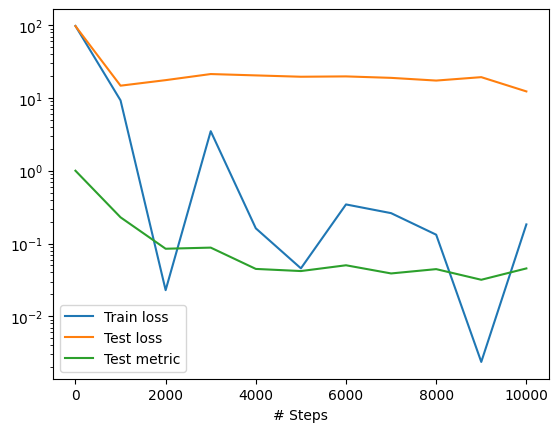

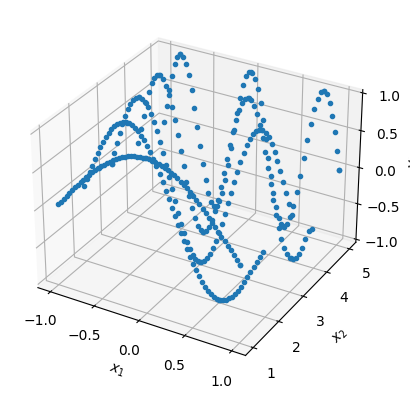

In [130]:
dde.saveplot(loss_history, train_state, issave=True, isplot=True)

In [131]:
model.predict([[1.0, 1.0]])

array([[-0.00276889]], dtype=float32)

In [132]:
def predict_for_n(points):
    prediction = model.predict(points)
    return np.array(prediction)

In [133]:
def plot_results_for_n(n, num_points=10):
    x = np.linspace(-L / 2, L / 2, num=num_points)
    points = np.array([[i, n] for i in x])
    predictions = predict_for_n(points)
    true_values = psi(points)
    
    fig, ax = plt.subplots()
    ax.plot(x, predictions, 'bo', label='predicted')
    ax.plot(x, true_values, '--', label='true')
    fig.legend()

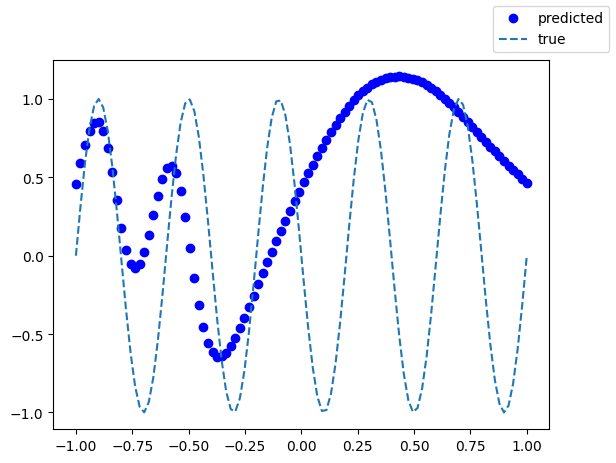

In [142]:
plot_results_for_n(10, 100)

In [ ]:
def plot_exact(n, num_points=10):
    x = np.linspace(-L / 2, L / 2, num=num_points)
    points = np.array([[i, n] for i in x])
    true_values = psi(points)
    
    fig, ax = plt.subplots()
    ax.plot(x, true_values, '--', label='true')
    fig.legend()

In [ ]:
plot_exact(1, 100)

In [ ]:
def psi_second(x):
    normalization_constant = np.sqrt(2.0 / L)
    n = x[:, 1:2]
    #k = (n * np.pi) / L
    
    result = []
    for i in range(n.shape[0]):
        k = (n[i] * np.pi) / L
        if n[i] % 2 == 0:            
            result.append(normalization_constant * np.sin(k * x[i, 0]))
        else:
            result.append(normalization_constant * np.cos(k * x[i, 0]))
    #print(result)
    return np.array(result)

In [ ]:
def compare_psis(n, num_points=100):
    x = np.linspace(-L / 2, L / 2, num=num_points)
    points = np.array([[i, n] for i in x])
    psi_values = psi(points) ** 2
    psi_second_values = psi_second(points) ** 2
    
    fig, ax = plt.subplots()
    ax.plot(x, psi_values, 'b--', label='psi')
    ax.plot(x, psi_second_values, 'r--', label='psi_second')
    fig.legend()

In [ ]:
compare_psis(4)

In [ ]:
plot_exact(10, 100)

In [ ]:
a = np.array([1,2,3])
b = np.array([4,5,6])
print(np.vstack([a,b]))
print(np.hstack([a,b]))
print(list(zip(a, b)))